In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# pick up csv file
OG_data = pd.read_csv("Données CHU PAP.csv", sep=";")

In [4]:
#copy for safety
DB = OG_data.copy()

In [5]:
#clean column heads to keep only the code
list1 = []
list2 = []
for e in DB.columns :
    list1.append(e)
for e in list1 :
    try:
        ind = e.index("#")
        list2.append(e[:ind]) 
    except : list2.append(e)
DB.columns = list2
DB.columns

Index(['Code_Local', '10.01', '10.02', '10.03', '10.04', '10.05', '10.06',
       '10.07', '10.08', '10.08e',
       ...
       'SV.50', 'SV.51', 'SW.11', 'SW.12', 'SW.13', 'SW.31', 'SW.41', 'SW.43',
       'SW.91', 'SW.99'],
      dtype='object', length=182)

In [6]:
#new features from the local code : extract building and service. The code looks like XX.X.XXX.XXX
list1 = []
list2 = []
list3 = []
for e in DB["Code_Local"]:
    ind = e.index(".")
    list1.append(e[(ind+1):])
    list2.append(e[:ind]) 

for e in list1 :
    ind = e.index(".")
    list3.append(e[:ind])
    
DB_test = DB.assign(Batiment=list2, Service=list3)

In [7]:
DB_HVAC = DB_test[['Batiment','Service','41.03','41.05','41.06','41.07', '41.08', '41.09']]
DB_HVAC_target = DB_test[['41.02']]
DB_HVAC.head()

,Batiment,Service,41.03,41.05,41.06,41.07,41.08,41.09
0,11,C,Aucun,S/R,NC (Air rafraîchi),NC (65% max),1 vol/h,1 vol/h
1,11,C,Aucun,S/R,NC (Air rafraîchi),NC (65% max),1 vol/h,1 vol/h
2,11,C,Aucun,S/R,NC (Air rafraîchi),NC (65% max),1 vol/h,1 vol/h
3,11,C,Aucun,S/R,NC (Air rafraîchi),NC (65% max),1 vol/h,1 vol/h
4,11,C,Aucun,S/R,NC (Air rafraîchi),NC (65% max),1 vol/h,1 vol/h


In [8]:
DB_HVAC_target.head()

,41.02
0,Double flux hygiénique
1,Double flux hygiénique
2,Double flux hygiénique
3,Double flux hygiénique
4,Double flux hygiénique


In [9]:
#Check routine. Some tools to similar things exist in pandas but this code suited my needs
def check_if_str(list):
    #counts the number of unique values which are strings
    uniq = np.unique(list)
    unilist = []
    for e in uniq :
        a = isinstance(e, str)
        unilist.append(a)
    return "String", unilist.count(True), "Other types", unilist.count(False)

check_if_str(DB_HVAC['41.05'])


('String', 10, 'Other types', 0)

# Data cleaning and processing
1. first, clean all spaces
2. clean special characters and punctuation. Careful when doing this, I removed all punctuation. Worked for the project fortunately
3. One hot Encoding

In [10]:
#testing some cleaning functions
from unidecode import unidecode
#remove special characters
s = unidecode("22°C!")

import string
#remove punctuation 
st = s.translate(str.maketrans('', '', string.punctuation))

s, st

('22degC!', '22degC')

In [15]:
#data cleaning functions
def series_cleaner(series) :
    name = series.name
    se = series.str.replace(' ', '', regex=True)
    li = se.tolist()
    lis = []
    for e in li :
        e = unidecode(e)
        ee = e.translate(str.maketrans('', '', string.punctuation))
        lis.append(ee)
    se = pd.Series( lis )
    se.name = name
    return se

def clean_series_with_0 (series, string):
    se = series.str.replace(string, '0')
    return se

def clean_series_multi_0 (series, list):
    #transforms the values of the list in the series with zeros
    for e in list :
        series = clean_series_with_0(series, e)
    return series



In [12]:
#One hot encoding to make the data suitable for an algorithm. The Sci-kit learn tool didn't give me the results I wanted
#from sklearn.preprocessing import OneHotEncoder 

def onehot_df (df) :
    columns = retrieve_series(df)
    df_ohe = df
    for column in columns :
        df_ohe = pd.concat([df_ohe, pd.get_dummies(column ,column.name, prefix_sep='_')], axis=1)
        df_ohe.drop(column.name, axis=1, inplace=True)
    return df_ohe


In [13]:
# data cleaning functions
def retrieve_series(df) : 
    series = []
    for e in df.columns.values :
        series.append(df[e])
    return series


def prepare_DB_all (df) :
    series = retrieve_series(df)
    series_cl = []
    for e in series :
        cl_col = series_cleaner(e)
        cl0_col = clean_series_multi_0(cl_col, ['-', ''])
        series_cl.append(cl_col)
    df_se = pd.concat(series_cl, axis=1)
    ohe_df = onehot_df(df_se)
    return ohe_df
        

In [16]:
#prepare the database
DB_target = pd.Series(data = DB_HVAC_target['41.02'], name ='Type de traitement')

DB_ohe_tot = prepare_DB_all(DB_HVAC)
DB_complete = pd.concat([DB_ohe_tot, DB_target], axis=1)
DB_complete.head()


,Batiment_11,Batiment_20,Batiment_31,Batiment_32,Batiment_33,Batiment_34,Batiment_40,Batiment_50,Service_C,Service_E,...,41.09_6volhenapportsmaxbase2volh,41.09_6volhenapportsmaxbase4volh,41.09_800m3hparextractionspecifique,41.09_8volh,41.09_8volh900m3hparextractionspecifique,41.09_8volhenapportsmaxbase1volh,41.09_8volhenapportsmaxbase2volh,41.09_8volhenapportsmaxbase4volh,41.09_8volhenapportsmaxbase6volh,Type de traitement
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Double flux hygiénique
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Double flux hygiénique
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Double flux hygiénique
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Double flux hygiénique
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Double flux hygiénique


# Machine learning

In [17]:
#test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(DB_complete.drop(columns=["Type de traitement"]), DB_complete["Type de traitement"], test_size=0.33, random_state=42)

X_train.head()


,Batiment_11,Batiment_20,Batiment_31,Batiment_32,Batiment_33,Batiment_34,Batiment_40,Batiment_50,Service_C,Service_E,...,41.09_6volhenapportsmaxbase1volh,41.09_6volhenapportsmaxbase2volh,41.09_6volhenapportsmaxbase4volh,41.09_800m3hparextractionspecifique,41.09_8volh,41.09_8volh900m3hparextractionspecifique,41.09_8volhenapportsmaxbase1volh,41.09_8volhenapportsmaxbase2volh,41.09_8volhenapportsmaxbase4volh,41.09_8volhenapportsmaxbase6volh
658,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1773,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3994,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
Y_test.head()

776      Reprise simple flux hygiénique
1666     Reprise simple flux hygiénique
1728             Double flux hygiénique
23               Double flux hygiénique
3337    Double flux, Ventilo-convecteur
Name: Type de traitement, dtype: object

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 658 to 860
Columns: 198 entries, Batiment_11 to 41.09_8volhenapportsmaxbase6volh
dtypes: uint8(198)
memory usage: 622.6 KB


In [38]:
#Create a decision tree classifier model
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, Y_train)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
#evaluate the model
from sklearn.metrics import accuracy_score
pred = tree_clf.predict(X_test)

score = accuracy_score(Y_test,pred, normalize=True, sample_weight=None)
score

0.9698360655737704

# Hyperparameters tuning
We tried to do some automated paramater tuning. It looks like the default values turned out to be almost optimal !

In [40]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree_clf, X_train, Y_train, cv=5, scoring='accuracy')

array([0.9517134 , 0.96031746, 0.95934959, 0.97704918, 0.97157191])

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'min_samples_leaf': [ 1, 10, 30, 300], 'max_features': [ 10, 100, 150]}
    ]

grid_search = GridSearchCV(tree_clf, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'min_samples_leaf': [1, 10, 30, 300], 'max_features': [10, 100, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [42]:
grid_search.best_params_

{'max_features': 150, 'min_samples_leaf': 1}

In [43]:
tree_clf2 = tree_clf = DecisionTreeClassifier(max_features=150, min_samples_leaf=1)
tree_clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=150, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
pred2 = tree_clf2.predict(X_test)
score = accuracy_score(Y_test,pred2, normalize=True, sample_weight=None)
score

0.9698360655737704

# Side note
A lot of things could have been done better for sure. It isn't a production ready model or anything. One thing to keep in mind is that the outcome we try to learn has many parameters, as shown in the histogram below. 
If the model only predicts the ones that are statistically frequent, we will get a good score anyway (that's not what is happening with this model, but it could happen). 


Our best way of improving the model here lies in the data : the engineers that gave the values put a lot of detail in the description of the HVAC system to be used. Therefore, by lowering a bit the detail, and only keeping the main aspects of the HVAC treatment, we could get data with way less possible values for the target we are trying to predict and a better prediction rate.

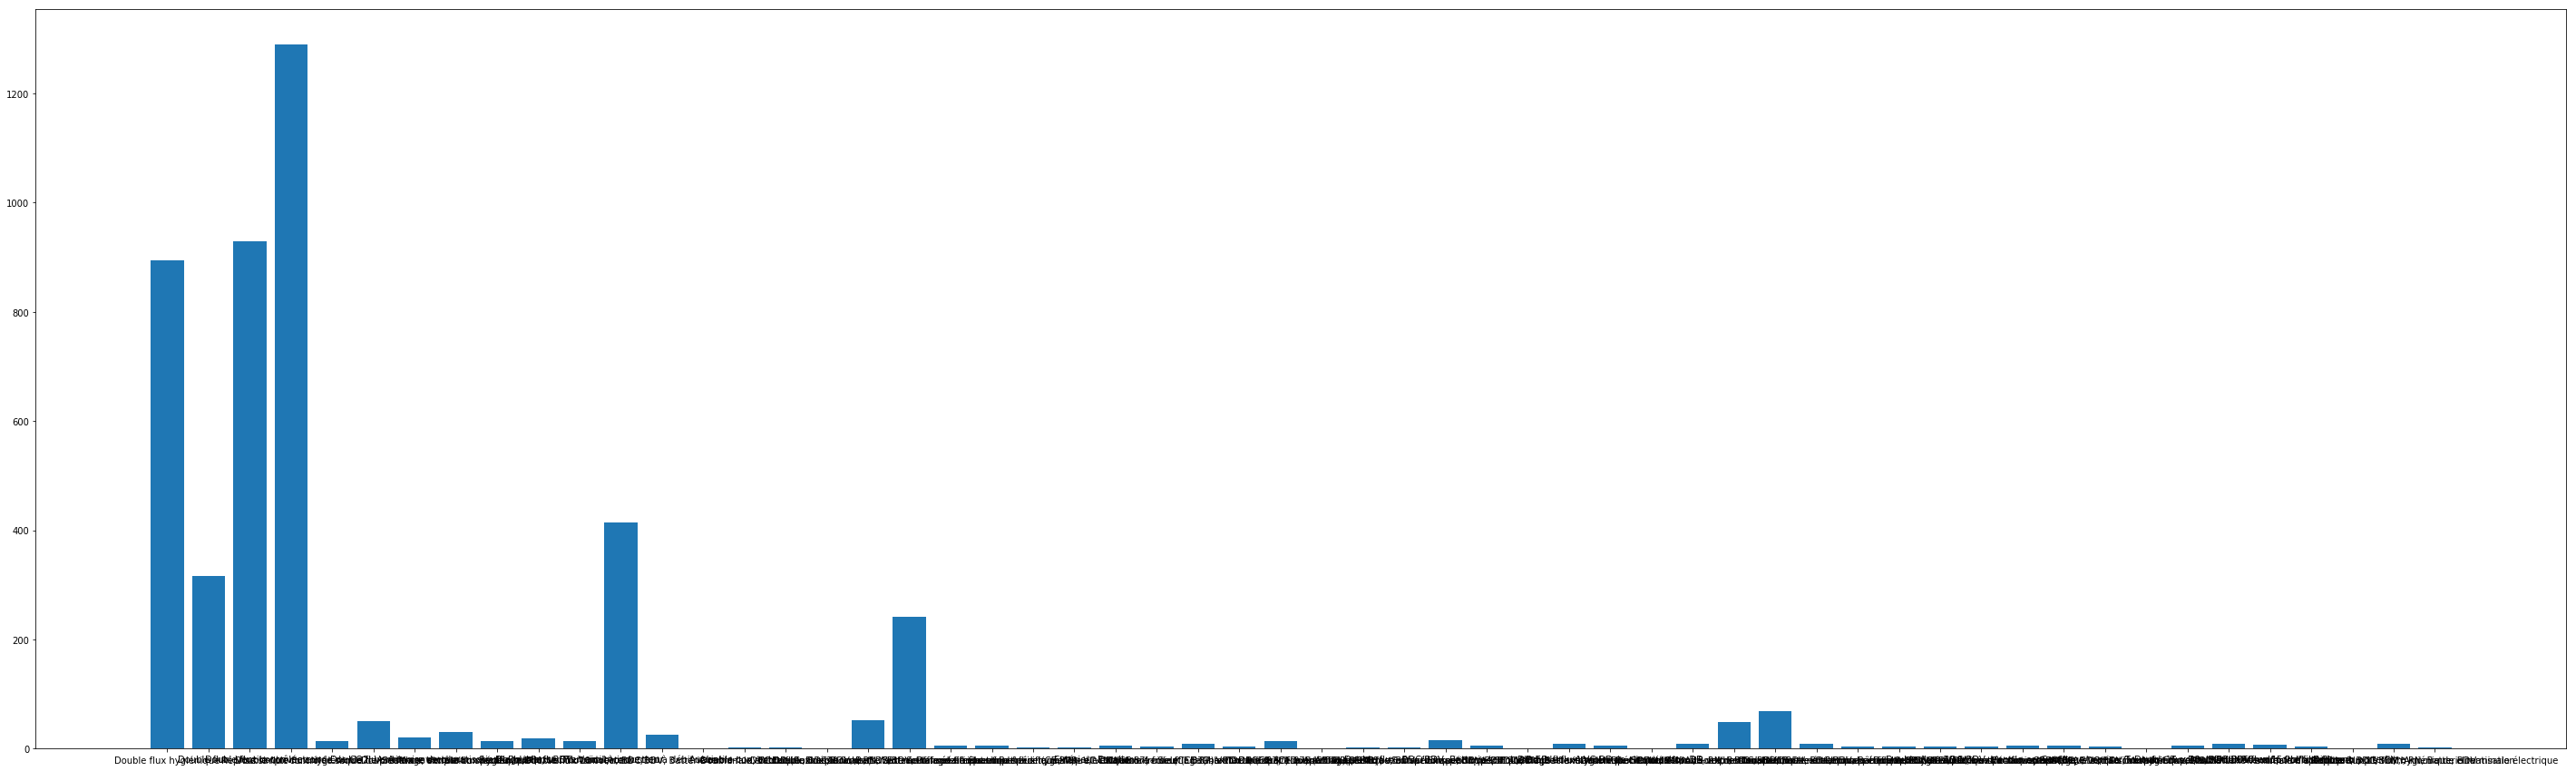

In [27]:
#histogram for target values

import collections
x = collections.Counter(DB_HVAC_target["41.02"])

plt.figure(figsize=(50,15))

l = []
for c in range(len(x.keys())): l.append(c)
    
plt.bar(l, x.values(), align='center' )
plt.xticks(l, x.keys())

plt.show()